In [ ]:
from propeller import PropellerGeometry
from mesh import PropellerMesh
from dynamics import SixDOFDynamics
from static import QuadcopterForceMoments
from vlm import VLM
from wind import WindField
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import copy
import pyvista as pv
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------_#
wake_states = []  # List to store states at each time step

# Initialize geometry and mesh
# propeller_geometry = PropellerGeometry(
#     airfoil_distribution_file='DJI9443_airfoils.csv',
#     chorddist_file='DJI9443_chorddist.csv',
#     pitchdist_file='DJI9443_pitchdist.csv',
#     sweepdist_file='DJI9443_sweepdist.csv',
#     heightdist_file='DJI9443_heightdist.csv',
#     R_tip=0.11938,
#     R_hub=0.00624,
#     num_blades=2
# )

propeller_geometry = PropellerGeometry(
    airfoil_distribution_file='NASA_UAM_quadrotor.csv',
    chorddist_file='NASA_UAM_quadrotor_chorddist.csv',
    pitchdist_file='NASA_UAM_quadrotor_pitchdist.csv',
    sweepdist_file='NASA_UAM_quadrotor_sweepdist.csv',
    R_tip=2.809,
    R_hub=0.3372,
    num_blades=3
)

propeller_mesh_system = PropellerMesh(propeller_geometry, arm_length=1.35, com=(0, 0, 0))
quad_propeller_mesh = propeller_mesh_system.generate_quad_propeller_mesh()

# Initialize SixDOF dynamics
mass = 0.68  # kg
inertia_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0, 0, 1.0]

])  # Simple diagonal inertia matrix for example

initial_position = np.array([0, 0, 0])  # Starting position
initial_body_velocity = np.array([0, 0, 0])  # Starting velocity
initial_orientation = np.array([0, 0, 0])  # Starting roll, pitch, yaw
initial_angular_velocity = np.array([0, 0, 0])  # Starting angular rates

rpm = 45
omega_dict = {  # Motor speed initialization
    'Propeller_1': np.array([0, 0, rpm]),
    'Propeller_2': np.array([0, 0, -rpm]),
    'Propeller_3': np.array([0, 0, -rpm]),
    'Propeller_4': np.array([0, 0, rpm])
}

# Initialize the UVLM solver
uvlm_solver = VLM(quad_propeller_mesh)

wake_states = []

dynamics = SixDOFDynamics(
    mass=mass,
    inertia_matrix=inertia_matrix,
    initial_position=np.zeros(3),
    initial_velocity_body=np.zeros(3),
    initial_angles=np.zeros(3),
    initial_angular_rates=np.zeros(3)
)

thrust_history = []
wake_history = []
time_points = []
normalized_forces = []
rho = 1.071778   

mesh = pv.read(r"bp_50percent_75.vtk") 
wind_field = WindField(mesh)
# wind_field = np.array([12, 5, 2])



n_revs = 2
n_steps_rev = 25
n_steps = n_revs * n_steps_rev
dt = 2*np.pi / (rpm * n_steps_rev)

probe_steps = 1


x_positions = np.linspace(342, 345, probe_steps) 
y_positions = [135]  # Three different y-positions to test
z_pos = 50  # Constant z position

moment_history = {y_pos: {
    'x_positions': [],
    'moments': {
        'Mx': [],
        'My': [],
        'Mz': []
    }
} for y_pos in y_positions}

for y_pos in y_positions:
    print(f"Testing y-position: {y_pos}")
    for x_pos  in x_positions:
        com_position = np.array([x_pos, y_pos, z_pos])

        print("Probe step:", x_pos)

        for time_step in range(1, n_steps_rev+1):

            print("Step per revolution:", time_step)
            
            # Step 1: Calculate forces and moments using UVLM
            forces_and_moments = uvlm_solver.calculate_total_forces_and_moments(
                propeller_mesh=quad_propeller_mesh,
                dt=dt,
                rho=rho,
                time_step=time_step,
                body_velocity=dynamics.velocity_body, 
                omega=omega_dict,
                wind_field=wind_field,
                com_position=com_position,
                roll=dynamics.angles[0],
                pitch=dynamics.angles[1],
                yaw=dynamics.angles[2]
            )
                    
            # Add thrust data collection here
            thrust_data = uvlm_solver.collect_thrust_data(
            quad_propeller_mesh,
            omega_dict,
            time_step,
            dt
            )
            
            thrust_history.append(thrust_data)
            total_force = np.zeros(3)

            total_moment = np.zeros(3)
            for prop_key in ['Propeller_1']:
                total_moment += forces_and_moments[prop_key]['moment']
                total_force += forces_and_moments[prop_key]['force']

            print(total_force)    
            # Store the position and moments
            if x_pos not in moment_history[y_pos]['x_positions']:
                moment_history[y_pos]['x_positions'].append(x_pos)
                moment_history[y_pos]['moments']['Mx'].append(total_moment[0])
                moment_history[y_pos]['moments']['My'].append(total_moment[1])
                moment_history[y_pos]['moments']['Mz'].append(total_moment[2])

            #  Step 2: Update mesh geometry for propeller rotation
            SixDOFDynamics.update_mesh_transformations(
                propeller_mesh=quad_propeller_mesh,
                dynamics=dynamics,
                dt=dt,
                omega_dict=omega_dict
            )
        
        # if x_pos not in moment_history['com_x']:
        #     moment_history['com_x'].append(x_pos)
                
        

            # # Step 3: Update wake
            # uvlm_solver.update_wake(
            #     propeller_mesh=quad_propeller_mesh,
            #     time_step=time_step,
            #     dt=dt,
            #     body_velocity=dynamics.velocity_body,
            #     omega_dict=omega_dict
            # )
            

            # fixed_radial_index = 3 
            # uvlm_solver.plot_span_gamma_distribution(quad_propeller_mesh, fixed_radial_index)

            # fixed_radial_index = 5 
            # uvlm_solver.plot_chord_gamma_distribution(quad_propeller_mesh, fixed_radial_index)
            # uvlm_solver.plot_detailed_gamma_distribution(quad_propeller_mesh)

            # uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, 
            #                     "Propeller_1", azimuth=0, elevation=30)

        #     uvlm_solver.plot_blades_pressure_top_view(
        #     quad_propeller_mesh,
        #     propeller_key="Propeller_1",
        #     omega=omega_dict["Propeller_1"], 
        #     body_velocity=initial_body_velocity,   
        #     rho=rho
        # )

        if thrust_history:  # Only if we have collected data
            uvlm_solver.plot_thrust_disk(thrust_history, n_steps_rev=n_steps_rev, R_hub=0.3372)

def plot_moments_combined(moment_history):
    """
    Create a plot showing moment components vs x-position for different y-positions
    with separate legends for moment types and y-positions.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    # Colors for each moment component
    colors = {
        'Mx': '#FB8861',  # Orange-red
        'My': '#F7D43B',  # Yellow
        'Mz': '#9C179E'   # Purple
    }
    
    # Line styles for different y-positions
    line_styles = {
        0: '-',    # solid
        1: '--',   # dashed
        2: ':',    # dotted
    }
    
    # Marker styles for different y-positions
    marker_styles = {
        0: 'o',    # circle
        1: 's',    # square
        2: '^',    # triangle
    }
    
    moment_lines = []  # Store lines for moment types legend
    position_lines = []  # Store lines for position legend
    labels = ['Rolling Moment', 'Pitching Moment', 'Yawing Moment']
    moment_keys = ['Mx', 'My', 'Mz']
    
    # First, create dummy lines for moment type legend
    for label, color in zip(labels, colors.values()):
        line = ax.plot([], [], color=color, label=label, linewidth=2.0)[0]
        moment_lines.append(line)
    
    # Then create dummy lines for position legend
    for y_idx, y_pos in enumerate(moment_history.keys()):
        line = ax.plot([], [], color='black', 
              linestyle=line_styles[y_idx],
              marker=marker_styles[y_idx],
              label=fr'$Y_{{\mathrm{{ECEF}}}}$ = {y_pos} m',  # Updated label
              markersize=8,
              markerfacecolor='white',
              markeredgewidth=2)[0]
        position_lines.append(line)
    
    # Now plot the actual data
    for y_idx, (y_pos, data) in enumerate(moment_history.items()):
        x_positions = np.array(data['x_positions'])
        
        for moment_key, color in zip(moment_keys, colors.values()):
            moment_values = np.array(data['moments'][moment_key])
            
            ax.plot(x_positions, moment_values,
                   color=color,
                   linestyle=line_styles[y_idx],
                   linewidth=2.0,
                   marker=marker_styles[y_idx],
                   markersize=8,
                   markevery=1,
                   markerfacecolor='white',
                   markeredgewidth=2,
                   zorder=3)
    
    # Customize axes
    ax.set_xlabel(r'$X_{ECEF}$ (m)', fontsize=20)
    ax.set_ylabel('Moment (N⋅m)', fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    
    # Add two legends
    # First legend for moment types
    legend1 = ax.legend(handles=moment_lines,
                       bbox_to_anchor=(0.5, -0.15),
                       loc='upper center',
                       fontsize=16,
                       ncol=3,
                       framealpha=1.0,
                       )
    
    # Add the first legend manually
    ax.add_artist(legend1)
    
    # Second legend for y-positions
    legend2 = ax.legend(handles=position_lines,
                       bbox_to_anchor=(0.5, -0.25),
                       loc='upper center',
                       fontsize=16,
                       ncol=3,
                       framealpha=1.0,
                       )
    
    # Customize grid and spines
    ax.grid(True, linestyle='--', alpha=0.2, zorder=1)
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.5)
    
    # # Set background color
    # ax.set_facecolor('white')
    # fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)  # Increased bottom margin for two legends
    
    # Save numerical data to CSV
    with open('moments_data_multi_y.csv', 'w') as f:
        # Write header
        header = 'y_position,x_position,Mx,My,Mz\n'
        f.write(header)
        
        # Write data for each y-position
        for y_pos, data in moment_history.items():
            for i, x_pos in enumerate(data['x_positions']):
                f.write(f'{y_pos},{x_pos},'
                       f'{data["moments"]["Mx"][i]},'
                       f'{data["moments"]["My"][i]},'
                       f'{data["moments"]["Mz"][i]}\n')
    
    plt.show()

# After your simulation loop completes, call the plotting function:
# plot_moments_combined(moment_history)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# 1. Load the data
df = pd.read_csv('detailed_multi_parameter_summary.csv')

# 2. Prepare the data
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# Verify the ranges
print(f"\nWind Magnitude range: {df['WindMagnitude'].min():.2f} to {df['WindMagnitude'].max():.2f}")
print(f"Angle range: {df['AngleDegrees'].min():.2f} to {df['AngleDegrees'].max():.2f}")
print(f"Azimuth values: {sorted(df['AzimuthAngle'].unique())}")

# 3. Reshape data to have one row per (magnitude, angle) combination with 10 Qz values
# Assume azimuth angles are 0, 36, 72, 108, 144, 180, 216, 252, 288, 324 (10 evenly spaced)
azimuth_angles = sorted(df['AzimuthAngle'].unique())
print(f"\nAzimuth angles ({len(azimuth_angles)}): {azimuth_angles}")

# Create pivot table
pivot_df = df.pivot_table(
    index=['WindMagnitude', 'AngleDegrees'], 
    columns='AzimuthAngle', 
    values='Qz'
)

# Reset index to make magnitude and angle regular columns
data_df = pivot_df.reset_index()

# The columns are now: WindMagnitude, AngleDegrees, and Qz values for each azimuth
print(f"\nReshaped data shape: {data_df.shape}")
print("First few rows:")
print(data_df.head())

# 4. Prepare features (X) and targets (y)
# Features: wind magnitude and angle
X = data_df[['WindMagnitude', 'AngleDegrees']].values

# Targets: Qz values for all 10 azimuths
qz_columns = [col for col in data_df.columns if col not in ['WindMagnitude', 'AngleDegrees']]
y = data_df[qz_columns].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target matrix shape: {y.shape}")

# 5. Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 6. Create and train the multi-output model
# This model predicts all 10 Qz values simultaneously
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_scaled, y)

print("\nModel trained successfully!")

# 7. Function to predict 10 Qz values from wind magnitude and angle
def predict_qz_values(wind_magnitude, angle_degrees):
    """Predict all 10 Qz values given wind magnitude and angle"""
    # Prepare input
    X_input = np.array([[wind_magnitude, angle_degrees]])
    X_input_scaled = scaler_X.transform(X_input)
    
    # Predict
    qz_values = model.predict(X_input_scaled)[0]
    
    # Return as dictionary for clarity
    result = {}
    for azimuth, qz in zip(azimuth_angles, qz_values):
        result[azimuth] = qz
    
    return result

# 8. Function for inverse prediction - find (magnitude, angle) from 10 Qz values
def predict_wind_params_from_qz(target_qz_values, method='grid_search'):
    """
    Predict wind magnitude and angle from 10 Qz values
    
    Args:
        target_qz_values: dict with azimuth angles as keys and Qz values as values
        method: 'grid_search' or 'optimization'
    """
    
    if method == 'grid_search':
        # Grid search approach
        mag_range = np.linspace(0, 12, 61)  # 61 points from 0 to 12
        angle_range = np.linspace(-20, 20, 41)  # 41 points from -20 to 20
        
        best_error = float('inf')
        best_result = None
        
        for mag in mag_range:
            for angle in angle_range:
                # Predict Qz values for this combination
                pred_qz = predict_qz_values(mag, angle)
                
                # Calculate total error
                error = 0
                for azimuth in azimuth_angles:
                    if azimuth in target_qz_values:
                        error += (pred_qz[azimuth] - target_qz_values[azimuth])**2
                
                if error < best_error:
                    best_error = error
                    best_result = {
                        'WindMagnitude': mag,
                        'AngleDegrees': angle,
                        'Error': error,
                        'RMSE': np.sqrt(error/len(azimuth_angles)),
                        'PredictedQz': pred_qz.copy()
                    }
        
        return best_result
    
    elif method == 'optimization':
        # Optimization approach
        def objective(params):
            mag, angle = params
            pred_qz = predict_qz_values(mag, angle)
            
            error = 0
            for azimuth in azimuth_angles:
                if azimuth in target_qz_values:
                    error += (pred_qz[azimuth] - target_qz_values[azimuth])**2
            
            return error
        
        # Initial guess
        x0 = [6, 0]  # middle of ranges
        
        # Bounds
        bounds = [(0, 12), (-20, 20)]
        
        # Optimize
        result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)
        
        if result.success:
            mag, angle = result.x
            pred_qz = predict_qz_values(mag, angle)
            
            return {
                'WindMagnitude': mag,
                'AngleDegrees': angle,
                'Error': result.fun,
                'RMSE': np.sqrt(result.fun/len(azimuth_angles)),
                'PredictedQz': pred_qz
            }
        else:
            return None

# 9. Test the model with an example
# Forward prediction
test_magnitude = 8
test_angle = 10

print(f"\n=== Forward Prediction Example ===")
print(f"Input: Wind Magnitude = {test_magnitude}, Angle = {test_angle}°")

predicted_qz = predict_qz_values(test_magnitude, test_angle)
print("\nPredicted Qz values:")
for azimuth, qz in predicted_qz.items():
    print(f"  Azimuth {azimuth}°: {qz:.4f}")

# Inverse prediction
print(f"\n=== Inverse Prediction Example ===")
print(f"Input: 10 Qz values (using the predicted values from above)")

# Using grid search
result_grid = predict_wind_params_from_qz(predicted_qz, method='grid_search')
print(f"\nGrid Search Result:")
print(f"  Predicted Wind Magnitude: {result_grid['WindMagnitude']:.2f}")
print(f"  Predicted Angle: {result_grid['AngleDegrees']:.2f}°")
print(f"  RMSE: {result_grid['RMSE']:.6f}")

# Using optimization
result_opt = predict_wind_params_from_qz(predicted_qz, method='optimization')
if result_opt:
    print(f"\nOptimization Result:")
    print(f"  Predicted Wind Magnitude: {result_opt['WindMagnitude']:.2f}")
    print(f"  Predicted Angle: {result_opt['AngleDegrees']:.2f}°")
    print(f"  RMSE: {result_opt['RMSE']:.6f}")

# 10. Visualization - Model performance
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, azimuth in enumerate(azimuth_angles):
    # Extract actual vs predicted for this azimuth
    actual = y[:, i]
    predicted = model.predict(X_scaled)[:, i]
    
    # Plot
    axes[i].scatter(actual, predicted, alpha=0.5, s=10)
    axes[i].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Qz')
    axes[i].set_ylabel('Predicted Qz')
    axes[i].set_title(f'Azimuth {azimuth}°')
    
    # Calculate R²
    r2 = np.corrcoef(actual, predicted)[0, 1]**2
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()

# 11. Save the model for later use
import joblib

joblib.dump(model, 'qz_multi_output_model.joblib')
joblib.dump(scaler_X, 'qz_feature_scaler.joblib')
joblib.dump(azimuth_angles, 'azimuth_angles.joblib')

print("\nModels saved successfully!")
# Example of how you'll use it later
qz_values = {
    0: 0.123,
    36: 0.145,
    72: 0.167,
    108: 0.189,
    144: 0.211,
    180: 0.233,
    216: 0.255,
    252: 0.277,
    288: 0.299,
    324: 0.321
}

result = predict_wind_params_from_qz(qz_values)
print(f"Predicted magnitude: {result['WindMagnitude']:.2f}")
print(f"Predicted angle: {result['AngleDegrees']:.2f}°")
# 12. Function to use for new predictions (after loading saved models)
def load_and_predict(wind_magnitude, angle_degrees, qz_values=None):
    """
    Load saved model and make predictions
    
    Args:
        wind_magnitude: Wind magnitude (0-12)
        angle_degrees: Angle degrees (-20 to 20)
        qz_values: If provided, performs inverse prediction
    """
    # Load models
    model = joblib.load('qz_multi_output_model.joblib')
    scaler_X = joblib.load('qz_feature_scaler.joblib')
    azimuth_angles = joblib.load('azimuth_angles.joblib')
    
    if qz_values is None:
        # Forward prediction
        X_input = np.array([[wind_magnitude, angle_degrees]])
        X_scaled = scaler_X.transform(X_input)
        predicted_qz = model.predict(X_scaled)[0]
        
        result = {}
        for azimuth, qz in zip(azimuth_angles, predicted_qz):
            result[azimuth] = qz
        return result
    else:
        # Inverse prediction (implement the same logic as above)
        pass

print("\nSetup complete! You can now:")
print("1. Use predict_qz_values(magnitude, angle) for forward prediction")
print("2. Use predict_wind_params_from_qz(qz_dict) for inverse prediction")

In [ ]:

import numpy as np
import joblib
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# 1. Load the trained model
print("Loading model...")
model = joblib.load('qz_multi_output_model.joblib')
scaler_X = joblib.load('qz_feature_scaler.joblib')
azimuth_angles = joblib.load('azimuth_angles.joblib')

print("Model loaded successfully!")
print(f"Azimuth angles: {azimuth_angles}")

# 2. Function to predict 10 Qz values from wind magnitude and angle
def predict_qz_values(wind_magnitude, angle_degrees):
    """Predict all 10 Qz values given wind magnitude and angle"""
    # Prepare input
    X_input = np.array([[wind_magnitude, angle_degrees]])
    X_input_scaled = scaler_X.transform(X_input)
    
    # Predict
    qz_values = model.predict(X_input_scaled)[0]
    
    # Return as dictionary
    result = {}
    for azimuth, qz in zip(azimuth_angles, qz_values):
        result[azimuth] = qz
    
    return result

# 3. Function for inverse prediction
def predict_wind_params_from_qz(target_qz_values):
    """
    Predict wind magnitude and angle from 10 Qz values
    
    Args:
        target_qz_values: dict with azimuth angles as keys and Qz values as values
    """
    
    def objective(params):
        mag, angle = params
        pred_qz = predict_qz_values(mag, angle)
        
        error = 0
        for azimuth in azimuth_angles:
            if azimuth in target_qz_values:
                error += (pred_qz[azimuth] - target_qz_values[azimuth])**2
        
        return error
    
    # Try multiple initial guesses to find global minimum
    best_result = None
    best_error = float('inf')
    
    initial_guesses = [
        [6, 0],      # center of ranges
        [3, -10],    # lower left
        [9, 10],     # upper right
        [3, 10],     # lower right
        [9, -10],    # upper left
    ]
    
    for x0 in initial_guesses:
        result = minimize(
            objective, 
            x0, 
            method='L-BFGS-B', 
            bounds=[(0, 12), (-20, 20)]
        )
        
        if result.success and result.fun < best_error:
            best_error = result.fun
            best_result = result
    
    if best_result is not None:
        mag, angle = best_result.x
        pred_qz = predict_qz_values(mag, angle)
        
        return {
            'WindMagnitude': mag,
            'AngleDegrees': angle,
            'Error': best_result.fun,
            'RMSE': np.sqrt(best_result.fun/len(azimuth_angles)),
            'PredictedQz': pred_qz
        }
    else:
        print("Optimization failed")
        return None

# 4. Example: Forward prediction
print("\n=== Example: Forward Prediction ===")
test_magnitude = 8.5
test_angle = 12.3

predicted_qz = predict_qz_values(test_magnitude, test_angle)
print(f"Input: Wind Magnitude = {test_magnitude}, Angle = {test_angle}°")
print("\nPredicted Qz values:")
for azimuth, qz in predicted_qz.items():
    print(f"  Azimuth {azimuth}°: {qz:.6f}")

# 5. Example: Inverse prediction (using the predicted values)
print("\n=== Example: Inverse Prediction ===")
print("Input: 10 Qz values (using the predicted values from above)")

result = predict_wind_params_from_qz(predicted_qz)
if result:
    print(f"\nResult:")
    print(f"  Predicted Wind Magnitude: {result['WindMagnitude']:.4f}")
    print(f"  Predicted Angle: {result['AngleDegrees']:.4f}°")
    print(f"  RMSE: {result['RMSE']:.8f}")
    
    print(f"\nOriginal values:")
    print(f"  Wind Magnitude: {test_magnitude}")
    print(f"  Angle: {test_angle}°")
    
    print(f"\nError:")
    print(f"  Magnitude error: {abs(result['WindMagnitude'] - test_magnitude):.6f}")
    print(f"  Angle error: {abs(result['AngleDegrees'] - test_angle):.6f}°")

# 6. Interactive function for your actual use case
def make_prediction(qz_values_dict):
    """
    Make prediction from your actual Qz values
    
    Args:
        qz_values_dict: Dictionary with azimuth angles as keys and Qz values as values
    """
    result = predict_wind_params_from_qz(qz_values_dict)
    
    if result:
        print("\n=== PREDICTION RESULT ===")
        print(f"Wind Magnitude: {result['WindMagnitude']:.4f}")
        print(f"Angle: {result['AngleDegrees']:.4f}°")
        print(f"RMSE: {result['RMSE']:.8f}")
        
        print("\nVerification - Forward prediction with these parameters:")
        verify_qz = predict_qz_values(result['WindMagnitude'], result['AngleDegrees'])
        
        print("\nComparison:")
        for azimuth in azimuth_angles:
            if azimuth in qz_values_dict:
                print(f"Azimuth {azimuth}°:")
                print(f"  Input Qz:     {qz_values_dict[azimuth]:.6f}")
                print(f"  Predicted Qz: {verify_qz[azimuth]:.6f}")
                print(f"  Error:        {abs(verify_qz[azimuth] - qz_values_dict[azimuth]):.8f}")
        
        return result
    else:
        print("Prediction failed")
        return None

# 7. Template for your actual use
print("\n" + "="*50)
print("TEMPLATE FOR YOUR ACTUAL USE")
print("="*50)
print("""
# When you have your actual Qz values, use this format:

your_qz_values = {
    0: 0.123456,      # Qz value for azimuth 0°
    36: 0.234567,     # Qz value for azimuth 36°
    72: 0.345678,     # Qz value for azimuth 72°
    108: 0.456789,    # Qz value for azimuth 108°
    144: 0.567890,    # Qz value for azimuth 144°
    180: 0.678901,    # Qz value for azimuth 180°
    216: 0.789012,    # Qz value for azimuth 216°
    252: 0.890123,    # Qz value for azimuth 252°
    288: 0.901234,    # Qz value for azimuth 288°
    324: 0.012345     # Qz value for azimuth 324°
}

# Make prediction
result = make_prediction(your_qz_values)
""")


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
df = pd.read_csv('wind_velocities.csv')

# Display the first few rows to verify the data
print("Original data preview:")
print(df.head())

# Calculate magnitude
df['wind_magnitude'] = np.sqrt(df['wind_velocity_x']**2 +
                              df['wind_velocity_y']**2 +
                              df['wind_velocity_z']**2)

# Calculate angle of attack (alpha)
# Using the x-component velocity and magnitude
df['alpha_rad'] = np.arccos(np.clip(np.abs(df['wind_velocity_x']) / df['wind_magnitude'], -1, 1))
df['alpha_deg'] = np.degrees(df['alpha_rad'])

# Handle any NaN values that might occur from division by zero
df['alpha_rad'] = df['alpha_rad'].fillna(0)
df['alpha_deg'] = df['alpha_deg'].fillna(0)

# Display results
print("\nResults preview:")
print(df[['wind_velocity_x', 'wind_velocity_y', 'wind_velocity_z', 
         'wind_magnitude', 'alpha_deg']].head())

# Save to a new CSV file
output_filename = 'wind_velocities_with_calculations.csv'
df.to_csv(output_filename, index=False)

print(f"\nResults saved to {output_filename}")

# Display statistics
print("\nStatistics:")
print("Wind Magnitude - Mean:", df['wind_magnitude'].mean())
print("Wind Magnitude - Max:", df['wind_magnitude'].max())
print("Wind Magnitude - Min:", df['wind_magnitude'].min())
print("Alpha (degrees) - Mean:", df['alpha_deg'].mean())
print("Alpha (degrees) - Max:", df['alpha_deg'].max())
print("Alpha (degrees) - Min:", df['alpha_deg'].min())

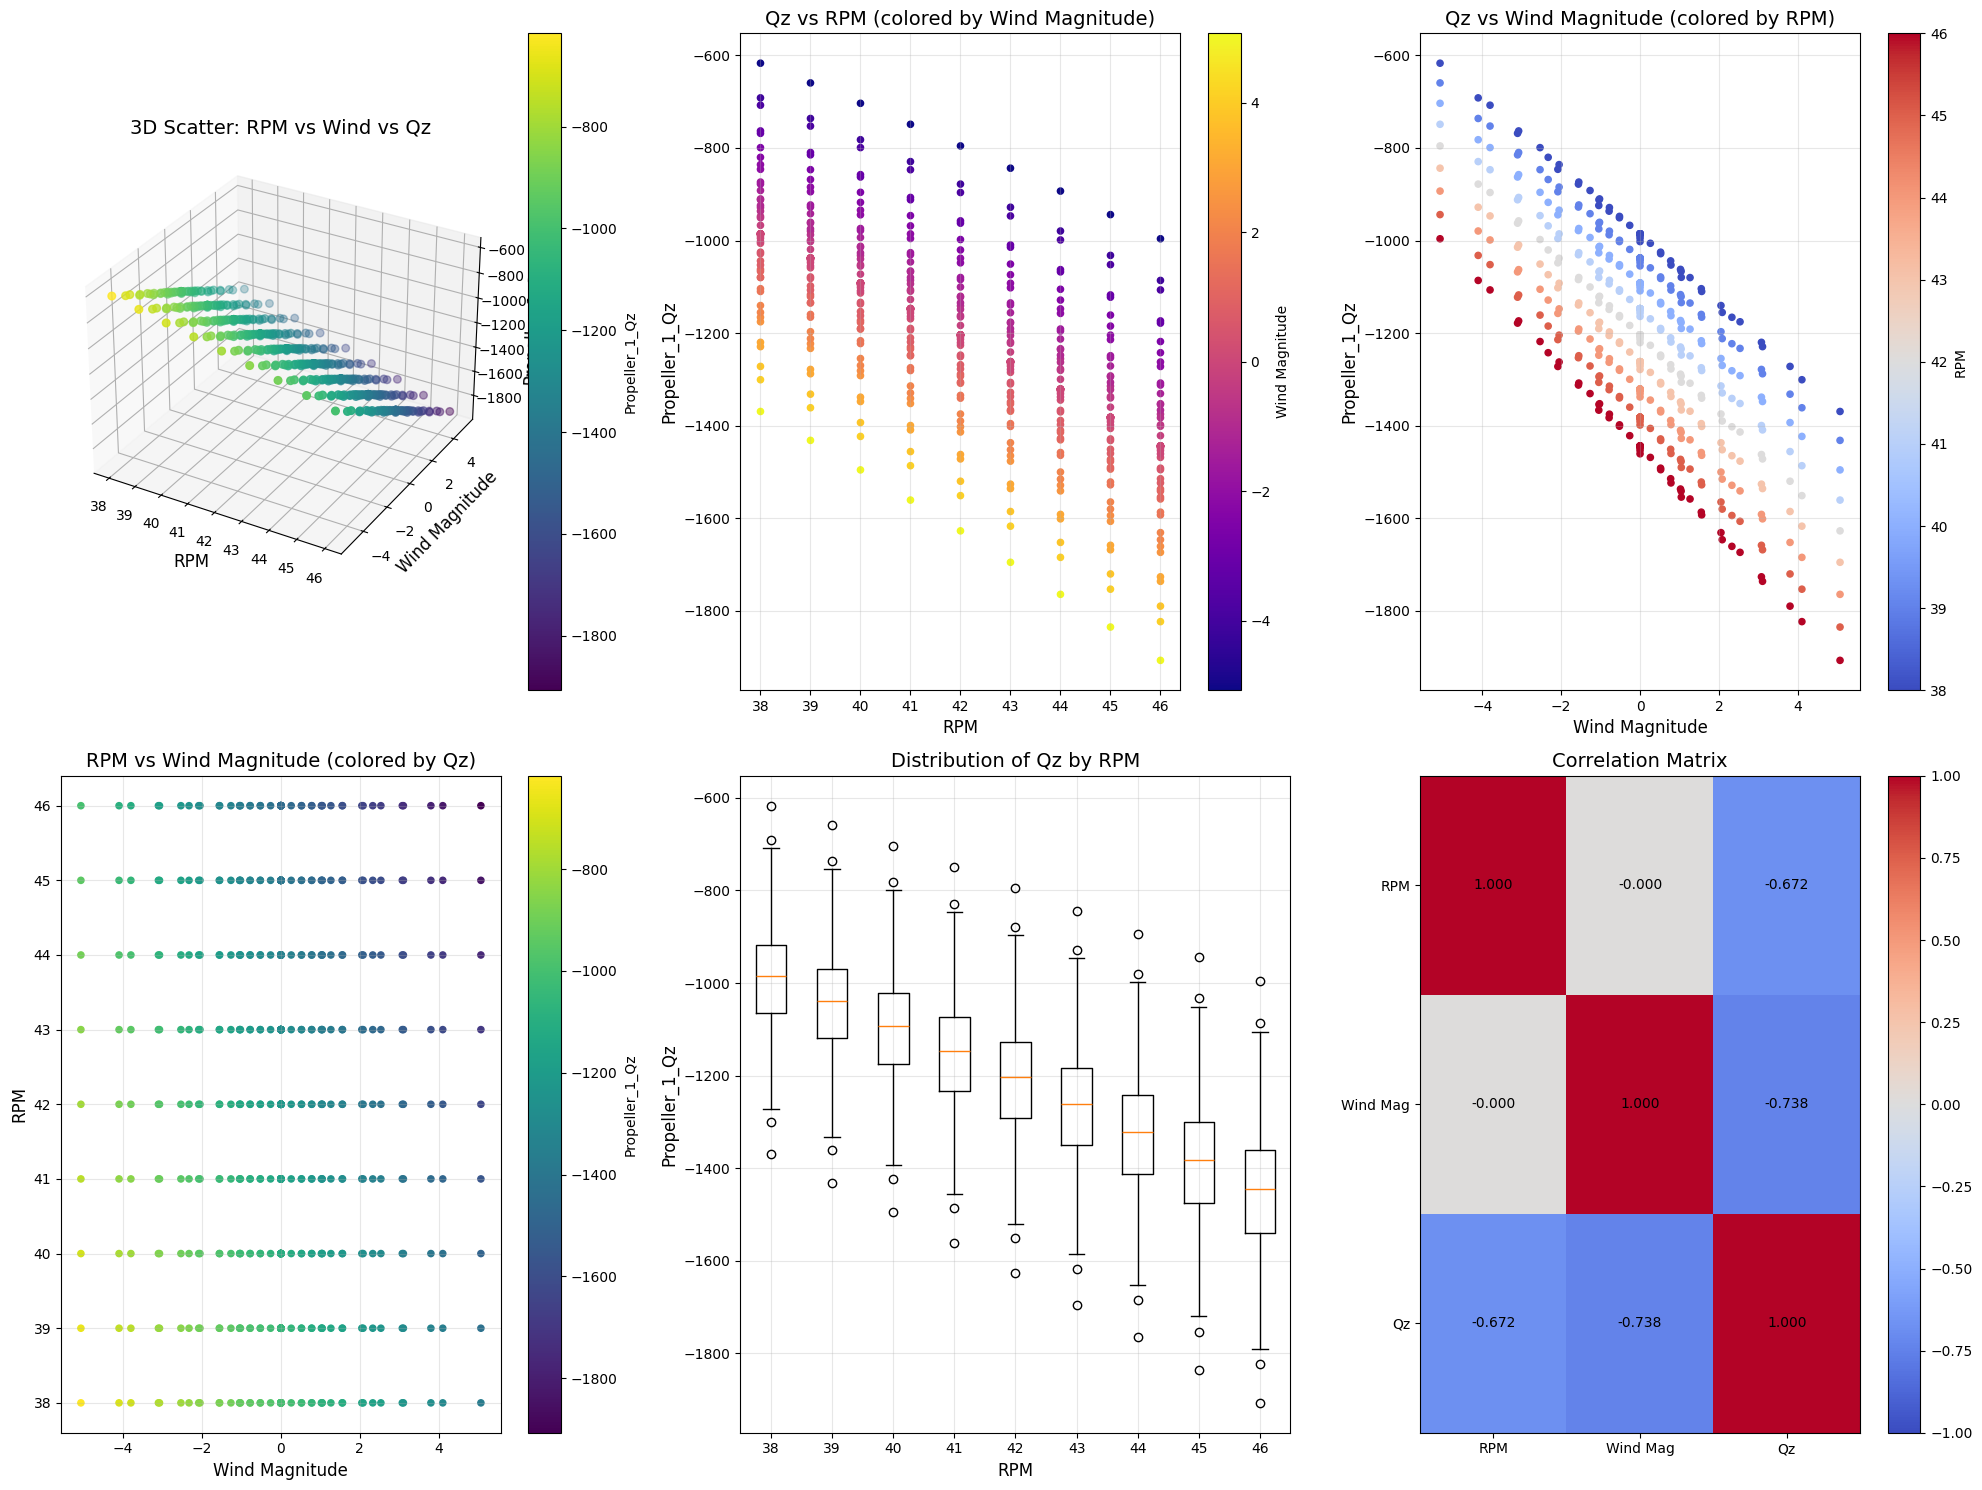

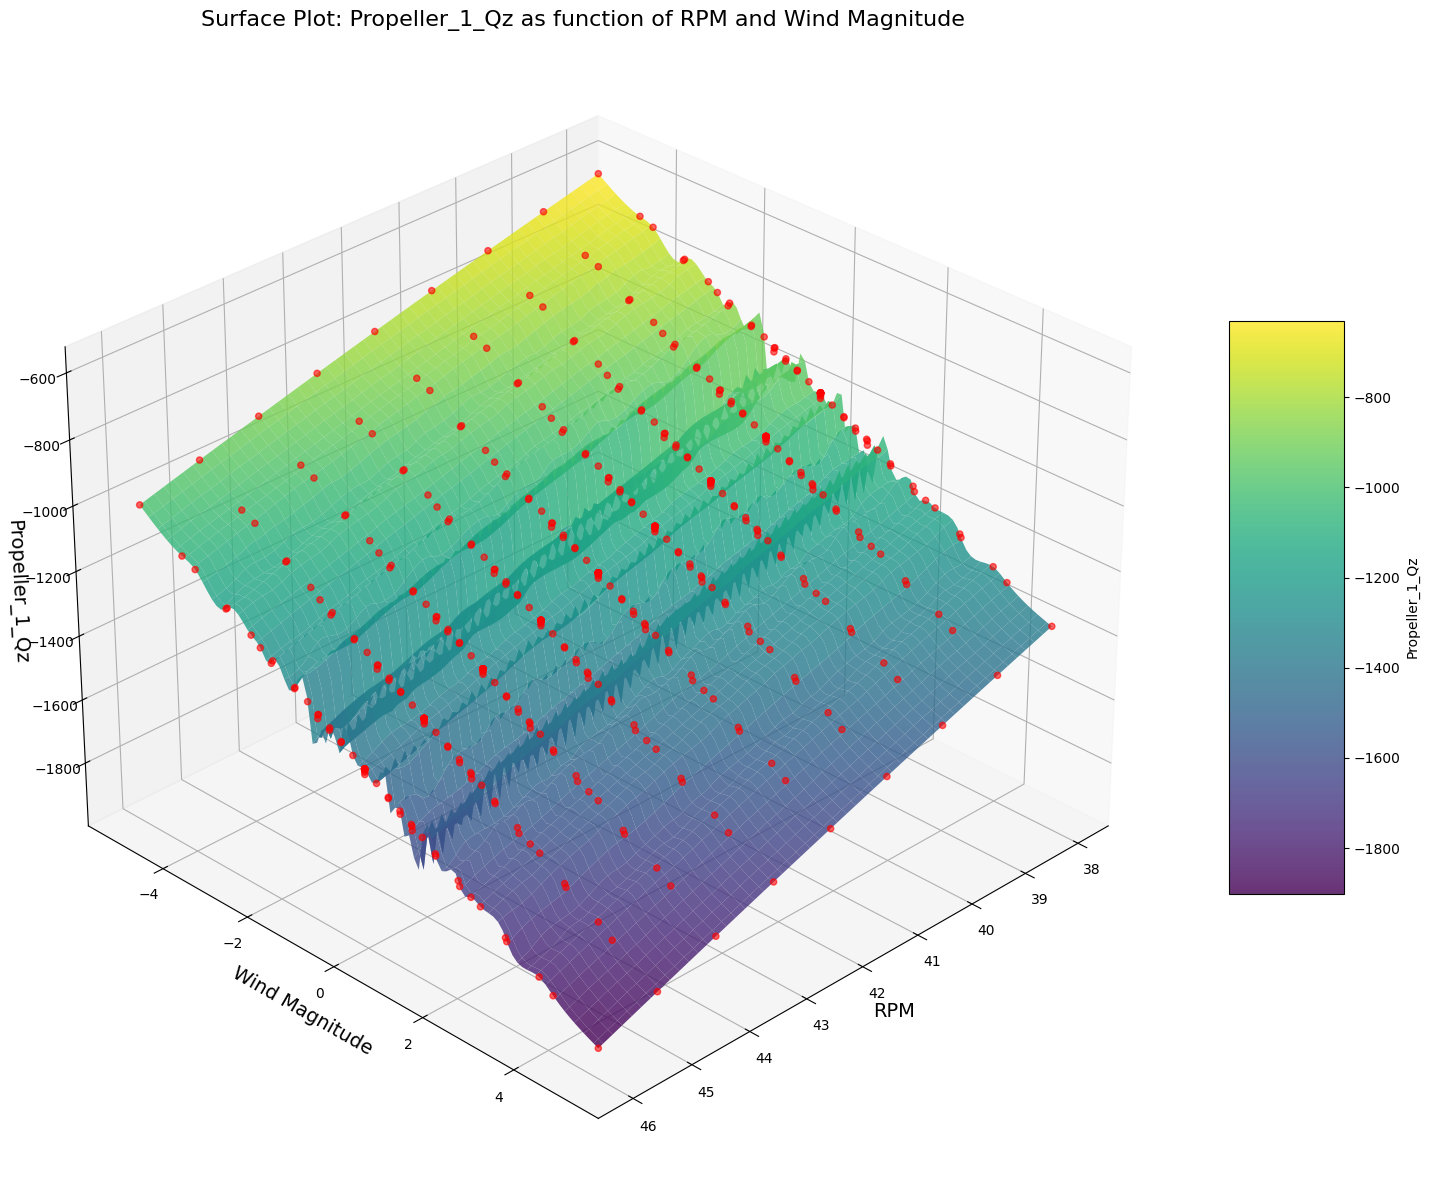

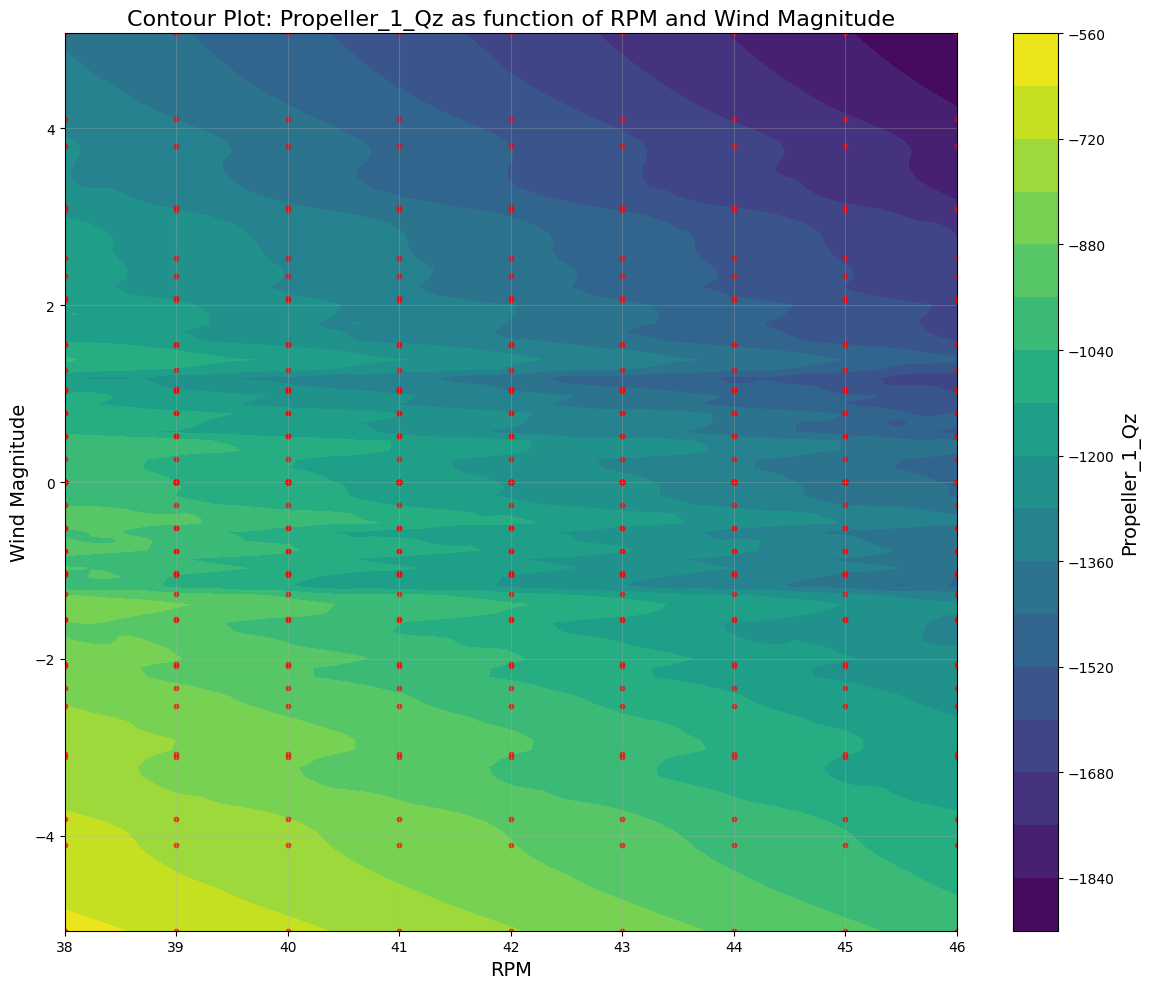

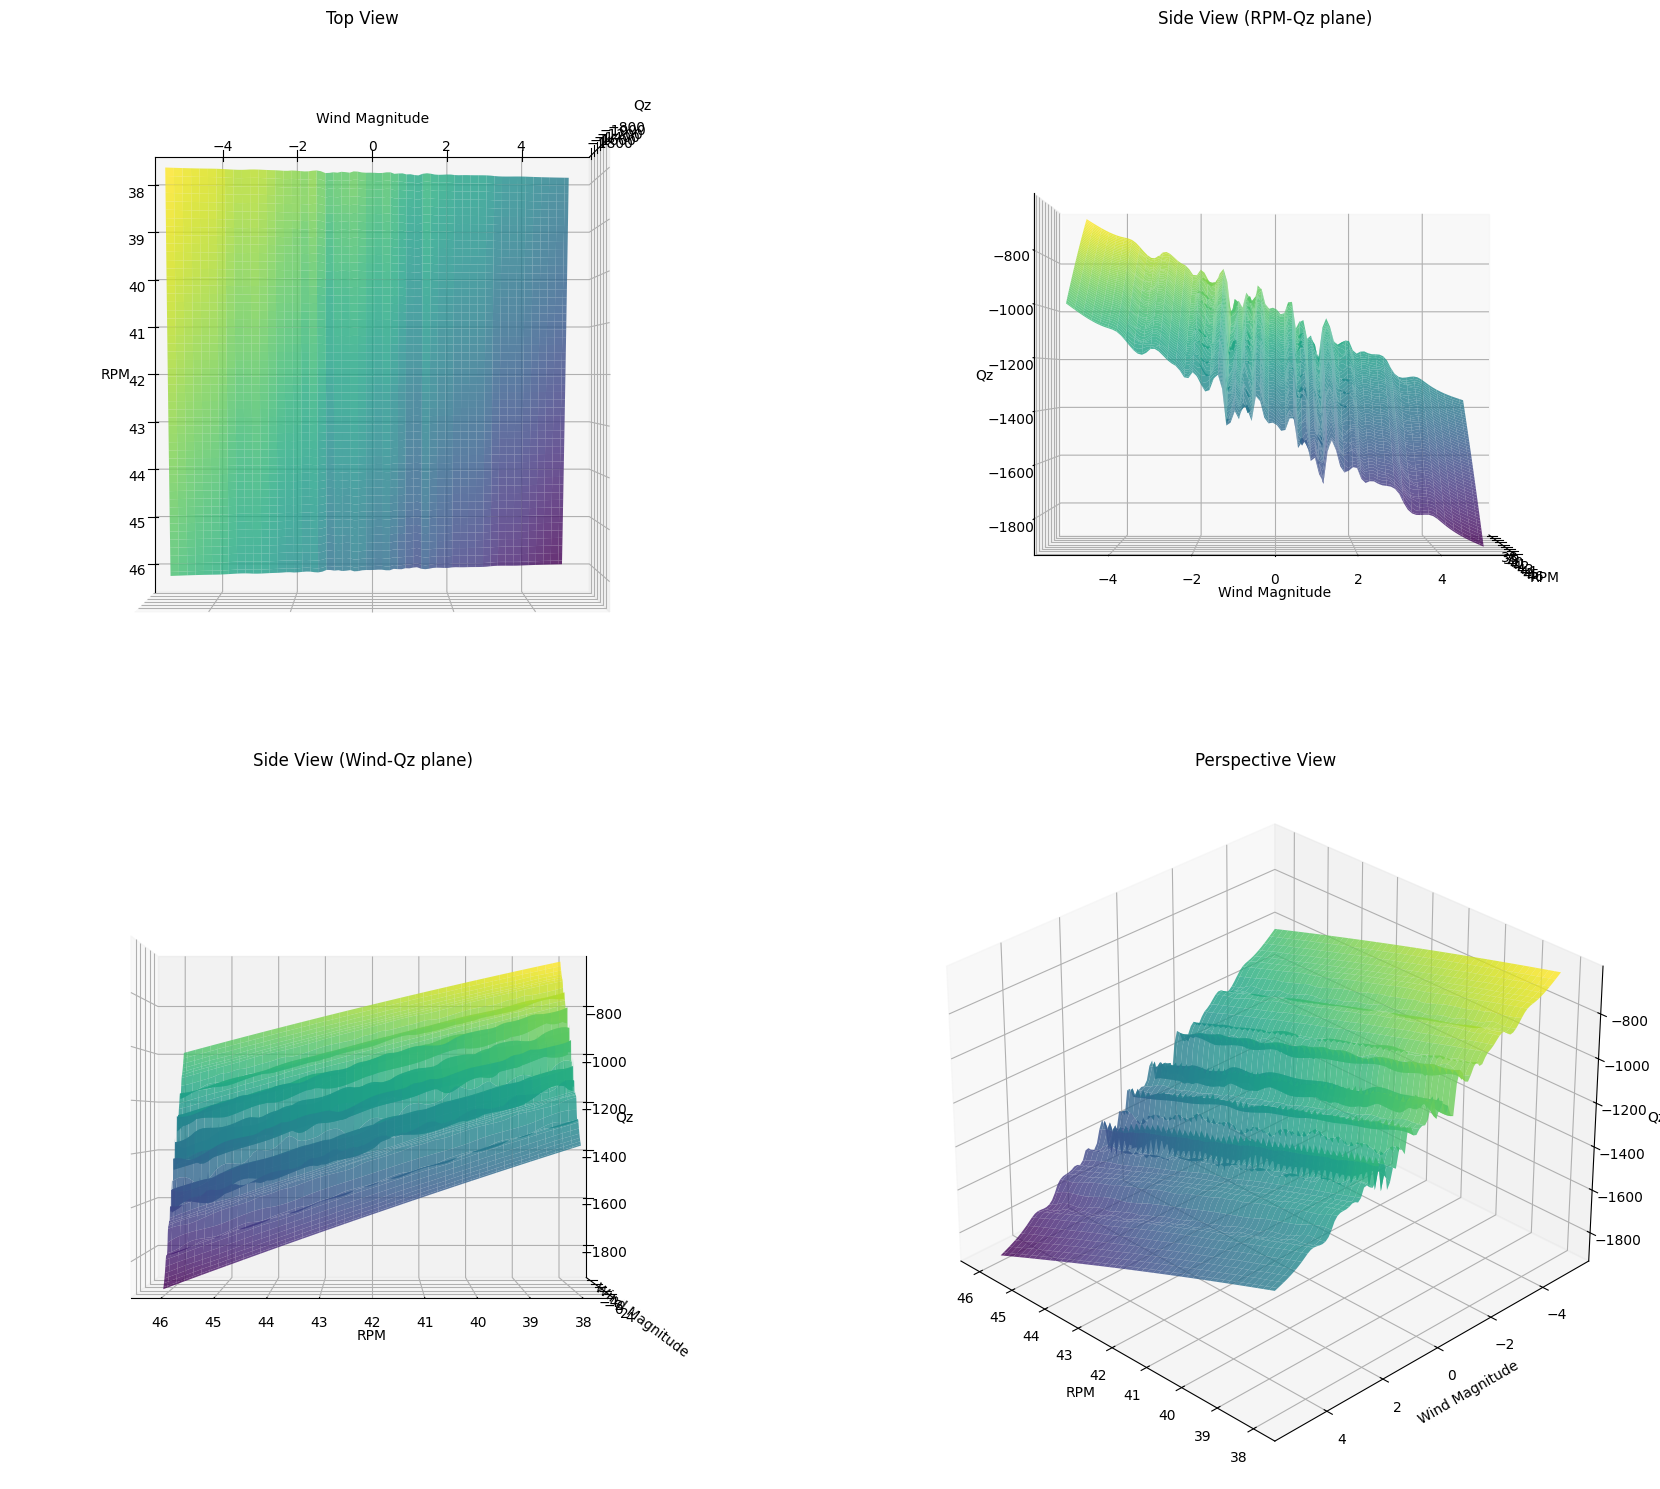

=== Summary Statistics ===
RPM range: 38.0 to 46.0
Wind Magnitude range: -5.071 to 5.071
Propeller_1_Qz range: -1907.193431 to -616.736886
Number of data points: 495

=== Correlation Analysis ===
Correlation between RPM and Qz: -0.672
Correlation between Wind Magnitude and Qz: -0.738
Correlation between RPM and Wind Magnitude: -0.000

Unique RPM values: [38 39 40 41 42 43 44 45 46]


In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Read the CSV file
df = pd.read_csv('rpm_wind_simulation_results_correct_3.csv')

# Extract the relevant columns
rpm = df['RPM'].values
wind_magnitude = df['WindZ'].values
propeller_qz = df['Propeller_1_Qz'].values

# Create comprehensive plots
fig = plt.figure(figsize=(20, 15))

# Plot 1: 3D scatter plot
ax1 = fig.add_subplot(231, projection='3d')
scatter = ax1.scatter(rpm, wind_magnitude, propeller_qz, c=propeller_qz, cmap='viridis', s=30)
ax1.set_xlabel('RPM', fontsize=12)
ax1.set_ylabel('Wind Magnitude', fontsize=12)
ax1.set_zlabel('Propeller_1_Qz', fontsize=12)
ax1.set_title('3D Scatter: RPM vs Wind vs Qz', fontsize=14)
plt.colorbar(scatter, ax=ax1, label='Propeller_1_Qz')

# Plot 2: Qz vs RPM (colored by wind magnitude)
ax2 = fig.add_subplot(232)
scatter2 = ax2.scatter(rpm, propeller_qz, c=wind_magnitude, cmap='plasma', s=20)
ax2.set_xlabel('RPM', fontsize=12)
ax2.set_ylabel('Propeller_1_Qz', fontsize=12)
ax2.set_title('Qz vs RPM (colored by Wind Magnitude)', fontsize=14)
plt.colorbar(scatter2, ax=ax2, label='Wind Magnitude')
ax2.grid(True, alpha=0.3)

# Plot 3: Qz vs Wind Magnitude (colored by RPM)
ax3 = fig.add_subplot(233)
scatter3 = ax3.scatter(wind_magnitude, propeller_qz, c=rpm, cmap='coolwarm', s=20)
ax3.set_xlabel('Wind Magnitude', fontsize=12)
ax3.set_ylabel('Propeller_1_Qz', fontsize=12)
ax3.set_title('Qz vs Wind Magnitude (colored by RPM)', fontsize=14)
plt.colorbar(scatter3, ax=ax3, label='RPM')
ax3.grid(True, alpha=0.3)

# Plot 4: RPM vs Wind Magnitude (colored by Qz)
ax4 = fig.add_subplot(234)
scatter4 = ax4.scatter(wind_magnitude, rpm, c=propeller_qz, cmap='viridis', s=20)
ax4.set_xlabel('Wind Magnitude', fontsize=12)
ax4.set_ylabel('RPM', fontsize=12)
ax4.set_title('RPM vs Wind Magnitude (colored by Qz)', fontsize=14)
plt.colorbar(scatter4, ax=ax4, label='Propeller_1_Qz')
ax4.grid(True, alpha=0.3)

# Plot 5: Box plot analysis
ax5 = fig.add_subplot(235)
# Group data by RPM for box plot
rpm_groups = np.unique(rpm)
qz_by_rpm = [propeller_qz[rpm == r] for r in rpm_groups]
ax5.boxplot(qz_by_rpm, labels=[f'{r:.0f}' for r in rpm_groups])
ax5.set_xlabel('RPM', fontsize=12)
ax5.set_ylabel('Propeller_1_Qz', fontsize=12)
ax5.set_title('Distribution of Qz by RPM', fontsize=14)
ax5.grid(True, alpha=0.3)

# Plot 6: Correlation heatmap
ax6 = fig.add_subplot(236)
correlation_data = np.column_stack([rpm, wind_magnitude, propeller_qz])
corr_matrix = np.corrcoef(correlation_data.T)
im = ax6.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax6.set_xticks([0, 1, 2])
ax6.set_yticks([0, 1, 2])
ax6.set_xticklabels(['RPM', 'Wind Mag', 'Qz'])
ax6.set_yticklabels(['RPM', 'Wind Mag', 'Qz'])
ax6.set_title('Correlation Matrix', fontsize=14)
plt.colorbar(im, ax=ax6)

# Add correlation values as text
for i in range(3):
    for j in range(3):
        text = ax6.text(j, i, f'{corr_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

# Create a surface plot
fig2 = plt.figure(figsize=(15, 12))

# Create grid for interpolation
rpm_range = np.linspace(rpm.min(), rpm.max(), 100)
wind_range = np.linspace(wind_magnitude.min(), wind_magnitude.max(), 100)
rpm_grid, wind_grid = np.meshgrid(rpm_range, wind_range)

# Interpolate Qz values onto the grid
qz_grid = griddata((rpm, wind_magnitude), propeller_qz, (rpm_grid, wind_grid), method='cubic')

# Create 3D surface plot
ax = fig2.add_subplot(111, projection='3d')
surf = ax.plot_surface(rpm_grid, wind_grid, qz_grid, cmap='viridis', alpha=0.8, 
                      linewidth=0, antialiased=True)

# Add scatter points on top of surface
ax.scatter(rpm, wind_magnitude, propeller_qz, c='red', s=20, alpha=0.6)

ax.set_xlabel('RPM', fontsize=14)
ax.set_ylabel('Wind Magnitude', fontsize=14)
ax.set_zlabel('Propeller_1_Qz', fontsize=14)
ax.set_title('Surface Plot: Propeller_1_Qz as function of RPM and Wind Magnitude', fontsize=16)

# Add colorbar
fig2.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Propeller_1_Qz')

# Set viewing angle for better visualization
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Create a contour plot
fig3, ax = plt.subplots(figsize=(12, 10))

# Create contour plot
contour = ax.contourf(rpm_grid, wind_grid, qz_grid, levels=20, cmap='viridis')
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Propeller_1_Qz', fontsize=14)

# Overlay scatter points
ax.scatter(rpm, wind_magnitude, c='red', s=10, alpha=0.6)

ax.set_xlabel('RPM', fontsize=14)
ax.set_ylabel('Wind Magnitude', fontsize=14)
ax.set_title('Contour Plot: Propeller_1_Qz as function of RPM and Wind Magnitude', fontsize=16)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create multiple views of the surface plot
fig4 = plt.figure(figsize=(20, 15))

# View 1: Top view
ax_top = fig4.add_subplot(221, projection='3d')
surf1 = ax_top.plot_surface(rpm_grid, wind_grid, qz_grid, cmap='viridis', alpha=0.8)
ax_top.view_init(elev=90, azim=0)  # Top view
ax_top.set_xlabel('RPM')
ax_top.set_ylabel('Wind Magnitude')
ax_top.set_zlabel('Qz')
ax_top.set_title('Top View')

# View 2: Side view 1
ax_side1 = fig4.add_subplot(222, projection='3d')
surf2 = ax_side1.plot_surface(rpm_grid, wind_grid, qz_grid, cmap='viridis', alpha=0.8)
ax_side1.view_init(elev=0, azim=0)  # Side view
ax_side1.set_xlabel('RPM')
ax_side1.set_ylabel('Wind Magnitude')
ax_side1.set_zlabel('Qz')
ax_side1.set_title('Side View (RPM-Qz plane)')

# View 3: Side view 2
ax_side2 = fig4.add_subplot(223, projection='3d')
surf3 = ax_side2.plot_surface(rpm_grid, wind_grid, qz_grid, cmap='viridis', alpha=0.8)
ax_side2.view_init(elev=0, azim=90)  # Side view
ax_side2.set_xlabel('RPM')
ax_side2.set_ylabel('Wind Magnitude')
ax_side2.set_zlabel('Qz')
ax_side2.set_title('Side View (Wind-Qz plane)')

# View 4: Perspective view
ax_persp = fig4.add_subplot(224, projection='3d')
surf4 = ax_persp.plot_surface(rpm_grid, wind_grid, qz_grid, cmap='viridis', alpha=0.8)
ax_persp.view_init(elev=30, azim=135)  # Perspective view
ax_persp.set_xlabel('RPM')
ax_persp.set_ylabel('Wind Magnitude')
ax_persp.set_zlabel('Qz')
ax_persp.set_title('Perspective View')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===")
print(f"RPM range: {rpm.min():.1f} to {rpm.max():.1f}")
print(f"Wind Magnitude range: {wind_magnitude.min():.3f} to {wind_magnitude.max():.3f}")
print(f"Propeller_1_Qz range: {propeller_qz.min():.6f} to {propeller_qz.max():.6f}")
print(f"Number of data points: {len(df)}")

# Show correlation values
print("\n=== Correlation Analysis ===")
print(f"Correlation between RPM and Qz: {np.corrcoef(rpm, propeller_qz)[0,1]:.3f}")
print(f"Correlation between Wind Magnitude and Qz: {np.corrcoef(wind_magnitude, propeller_qz)[0,1]:.3f}")
print(f"Correlation between RPM and Wind Magnitude: {np.corrcoef(rpm, wind_magnitude)[0,1]:.3f}")

# Show unique RPM values
unique_rpm = np.unique(rpm)
print(f"\nUnique RPM values: {unique_rpm}")

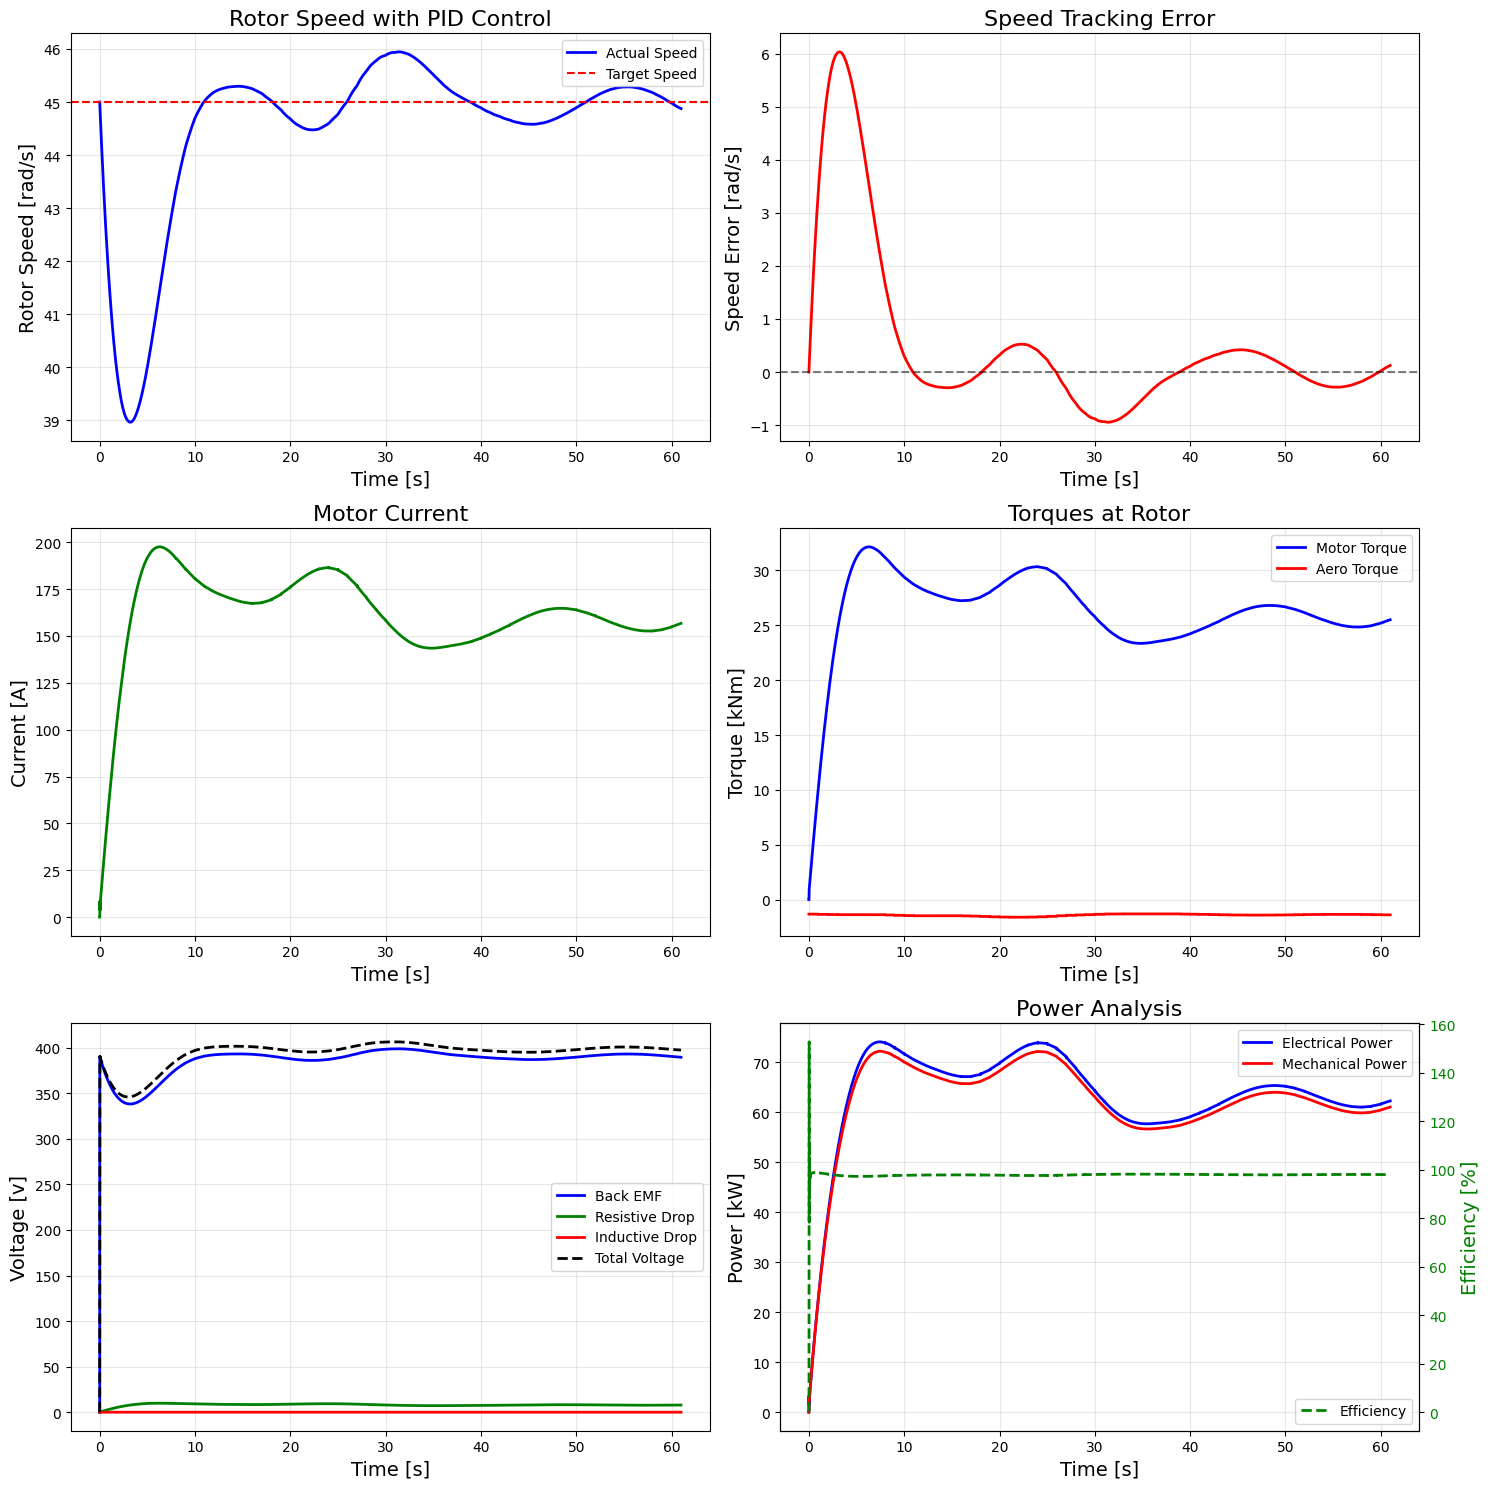

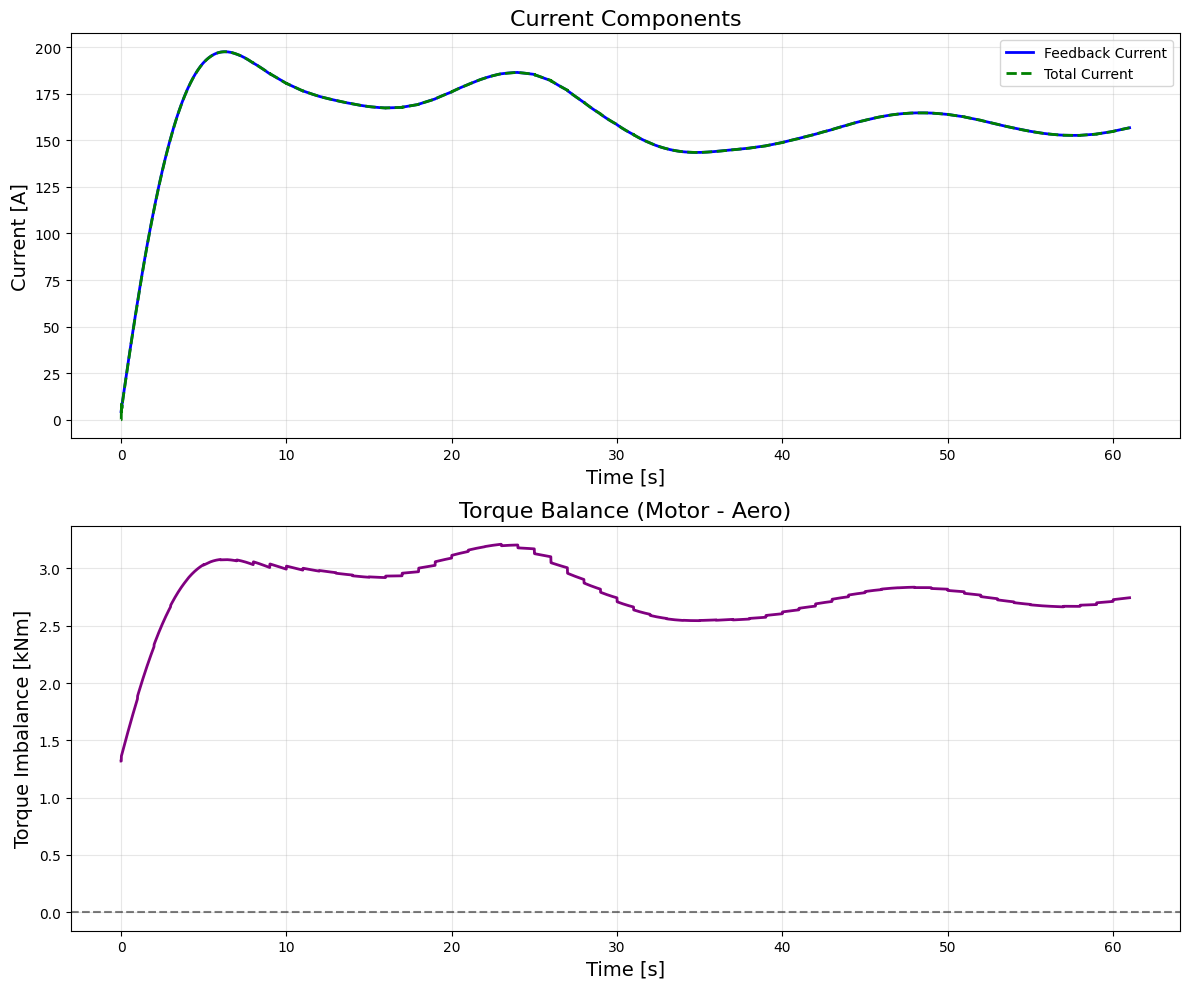


=== System Performance Metrics ===
Target Speed: 45.0 rad/s
Final Speed: 44.8774 rad/s
Steady-State Error: 0.1614 rad/s (0.36%)
Peak Current: 197.48 A
Average Current: 157.14 A
Peak Voltage: 406.48 V
Average Efficiency: 98.0%
Average Mechanical Power: 61.53 kW
Average Electrical Power: 62.77 kW


In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load torque data ===
torque_df = pd.read_csv('torque_data.csv')
torque_z = torque_df['torque_z'].values  # Q_aero values at 1 Hz

# === Simulation Setup ===
dt = 0.01
steps_per_second = int(1 / dt)
sim_time = len(torque_z)
n_steps = sim_time * steps_per_second
time_array = np.arange(0, sim_time, dt)

# === Expand Q_aero for full time resolution ===
Q_aero_full = np.repeat(torque_z, steps_per_second)[:n_steps]

# === Constants ===
J_rot = 0.064         # kg·m²
I_r = 274.69          # kg·m²
r = 18.75             # Gear ratio
L = 0.3e-3            # H
R = 0.05              # Ohm
K_Q = 0.463           # Nm/A
K_V = 0.463           # V·s/rad
total_inertia = J_rot * r**2 + I_r

# === Desired Rotor Speed ===
Omega_desired = 45.0  # rad/s

# === Initialize states ===
Omega = np.zeros(n_steps)
omega = np.zeros(n_steps)
i_vals = np.zeros(n_steps)
v_vals = np.zeros(n_steps)
Q_m_vals = np.zeros(n_steps)
v_m_vals = np.zeros(n_steps)
Omega[0] = 45.0  # Initialize rotor speed to 45 rad/s
# === Control Gains ===
Kp = 15.0     # Proportional gain
Ki = 5.0      # Integral gain
Kd = 1.0      # Derivative gain
integral_error = 0  # Initialize integral term
previous_error = 0.0  # Initialize previous error for derivative term

# === Simulation Loop ===
for t in range(1, n_steps):
    # Feedback: rotor speed error
    error = Omega_desired - Omega[t - 1]
    
    # Update integral term
    integral_error += error * dt
    
    # Anti-windup: limit integral term
    integral_error = np.clip(integral_error, -50, 50)
    
    # Derivative term (difference of current error and previous error)
    derivative_error = (error - previous_error) / dt
    
    # PID controller to compute desired current
    i_desired = Kp * error + Ki * integral_error + Kd * derivative_error
    
    # Total desired current (no feedforward)
    i_total = i_desired
    
    # Limit current (optional safety)
    i_total = np.clip(i_total, -300, 300)
    
    # Motor torque from current
    Q_m = r * i_total * K_Q
    
    # Rotor dynamics
    dOmega_dt = (Q_m + Q_aero_full[t]) / total_inertia
    Omega[t] = Omega[t - 1] + dOmega_dt * dt
    
    # Motor shaft speed
    omega[t] = r * Omega[t]
    
    # Electrical dynamics (first-order response)
    tau_e = L/R  # Electrical time constant
    di_dt = (i_total - i_vals[t - 1]) / tau_e
    i_vals[t] = i_vals[t - 1] + di_dt * dt
    
    # Back EMF and voltage
    v_m = omega[t] * K_V
    v = v_m + i_vals[t] * R
    
    # For plotting: include inductive term
    v_inductive = L * (i_vals[t] - i_vals[t-1]) / dt
    v_total = v_m + i_vals[t] * R + v_inductive
    
    # Save values
    Q_m_vals[t] = Q_m
    v_m_vals[t] = v_m
    v_vals[t] = v_total
    
    # Update previous error for derivative calculation
    previous_error = error

# === Calculate additional variables for analysis ===
error_vals = Omega_desired - Omega
power_electrical = v_vals * i_vals
power_mechanical = Q_m_vals * omega / r
efficiency = np.divide(power_mechanical, power_electrical, 
                      out=np.zeros_like(power_mechanical), 
                      where=power_electrical!=0) * 100

# === Create comprehensive plots ===
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot 1: Rotor Speed
axes[0, 0].plot(time_array, Omega, 'b-', linewidth=2, label='Actual Speed')
axes[0, 0].axhline(Omega_desired, color='r', linestyle='--', label='Target Speed')
axes[0, 0].set_xlabel('Time [s]', fontsize=14)
axes[0, 0].set_ylabel('Rotor Speed [rad/s]', fontsize=14)
axes[0, 0].set_title('Rotor Speed with PID Control', fontsize=16)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Speed Error
axes[0, 1].plot(time_array, error_vals, 'r-', linewidth=2)
axes[0, 1].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Time [s]', fontsize=14)
axes[0, 1].set_ylabel('Speed Error [rad/s]', fontsize=14)
axes[0, 1].set_title('Speed Tracking Error', fontsize=16)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Motor Current
axes[1, 0].plot(time_array, i_vals, 'g-', linewidth=2)
axes[1, 0].set_xlabel('Time [s]', fontsize=14)
axes[1, 0].set_ylabel('Current [A]', fontsize=14)
axes[1, 0].set_title('Motor Current', fontsize=16)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Torques
axes[1, 1].plot(time_array, Q_m_vals * r / 1000, 'b-', linewidth=2, label='Motor Torque')
axes[1, 1].plot(time_array, Q_aero_full / 1000, 'r-', linewidth=2, label='Aero Torque', drawstyle='steps-post')
axes[1, 1].set_xlabel('Time [s]', fontsize=14)
axes[1, 1].set_ylabel('Torque [kNm]', fontsize=14)
axes[1, 1].set_title('Torques at Rotor', fontsize=16)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Voltage Components
v_resistive = i_vals * R
v_inductive = L * np.gradient(i_vals, dt)
axes[2, 0].plot(time_array, v_m_vals, 'b-', linewidth=2, label='Back EMF')
axes[2, 0].plot(time_array, v_resistive, 'g-', linewidth=2, label='Resistive Drop')
axes[2, 0].plot(time_array, v_inductive, 'r-', linewidth=2, label='Inductive Drop')
axes[2, 0].plot(time_array, v_vals, 'k--', linewidth=2, label='Total Voltage')
axes[2, 0].set_xlabel('Time [s]', fontsize=14)
axes[2, 0].set_ylabel('Voltage [v]', fontsize=14)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Power and Efficiency
ax6 = axes[2, 1]
ax6.plot(time_array, power_electrical/1000, 'b-', linewidth=2, label='Electrical Power')
ax6.plot(time_array, power_mechanical/1000, 'r-', linewidth=2, label='Mechanical Power')
ax6.set_xlabel('Time [s]', fontsize=14)
ax6.set_ylabel('Power [kW]', fontsize=14)
ax6.set_title('Power Analysis', fontsize=16)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Add efficiency on secondary axis
ax6_twin = ax6.twinx()
ax6_twin.plot(time_array, efficiency, 'g--', linewidth=2, label='Efficiency')
ax6_twin.set_ylabel('Efficiency [%]', fontsize=14, color='g')
ax6_twin.tick_params(axis='y', labelcolor='g')
ax6_twin.legend(loc='lower right')

plt.tight_layout()
plt.show()

# === Additional Analysis Plots ===
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot current components
i_feedback = Kp * error_vals + Ki * np.cumsum(error_vals * dt) + Kd * np.gradient(error_vals, dt)
ax1.plot(time_array, i_feedback, 'b-', linewidth=2, label='Feedback Current')
ax1.plot(time_array, i_vals, 'g--', linewidth=2, label='Total Current')
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('Current [A]', fontsize=14)
ax1.set_title('Current Components', fontsize=16)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot torque balance
torque_balance = Q_m_vals - Q_aero_full
ax2.plot(time_array, torque_balance/1000, 'purple', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time [s]', fontsize=14)
ax2.set_ylabel('Torque Imbalance [kNm]', fontsize=14)
ax2.set_title('Torque Balance (Motor - Aero)', fontsize=16)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === Performance Metrics ===
# Calculate settling time (within 2% of target)
settling_idx = np.where(np.abs(error_vals) < 0.02 * Omega_desired)[0]
settling_time = time_array[settling_idx[0]] if len(settling_idx) > 0 else None

# Steady-state analysis (last 20% of simulation)
steady_start = int(0.8 * n_steps)
steady_state_error = np.mean(np.abs(error_vals[steady_start:]))

print("\n=== System Performance Metrics ===")
print(f"Target Speed: {Omega_desired} rad/s")
print(f"Final Speed: {Omega[-1]:.4f} rad/s")
print(f"Steady-State Error: {steady_state_error:.4f} rad/s ({steady_state_error/Omega_desired*100:.2f}%)")
if settling_time:
    print(f"Settling Time: {settling_time:.2f} s")
print(f"Peak Current: {np.max(np.abs(i_vals)):.2f} A")
print(f"Average Current: {np.mean(np.abs(i_vals[steady_start:])):.2f} A")
print(f"Peak Voltage: {np.max(np.abs(v_vals)):.2f} V")
print(f"Average Efficiency: {np.mean(efficiency[steady_start:]):.1f}%")
print(f"Average Mechanical Power: {np.mean(power_mechanical[steady_start:])/1000:.2f} kW")
print(f"Average Electrical Power: {np.mean(power_electrical[steady_start:])/1000:.2f} kW")


In [309]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Read the CSV file
df = pd.read_csv('rpm_wind_simulation_results_correct_3.csv')

# Extract the input (features) and output (target)
X = df[['RPM', 'Propeller_1_Qz']].values          # Independent variables
y = df['WindZ'].values         # Dependent variable

# Choose polynomial degree
degree = 3  # You can try 3, 4, etc. for more complexity

# Generate polynomial features
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict using the model
y_pred = model.predict(X_poly)

# Evaluate the fit
r2 = r2_score(y, y_pred)
print(f"R² score: {r2:.4f}")

# Get the names of the polynomial terms
feature_names = poly.get_feature_names_out(['RPM', 'Propeller_1_Qz'])

# Construct the polynomial equation
equation = "y = " + f"{model.intercept_:.6f}"  # Start with the intercept term
for name, coef in zip(feature_names[1:], model.coef_[1:]):  # Skip the first term as it's the intercept
    equation += f" + ({coef:.6f}) * {name}"

# Print the polynomial equation
print(f"Polynomial Equation: {equation}")


R² score: 0.9991
Polynomial Equation: y = 13.195318 + (-1.237085) * RPM + (-0.033724) * Propeller_1_Qz + (0.019313) * RPM^2 + (0.000680) * RPM Propeller_1_Qz + (-0.000001) * Propeller_1_Qz^2 + (-0.000149) * RPM^3 + (-0.000005) * RPM^2 Propeller_1_Qz + (0.000000) * RPM Propeller_1_Qz^2 + (-0.000000) * Propeller_1_Qz^3


    RotorSpeed_rads  AeroTorque_Nm  Predicted_WindZ
0         45.000000    1281.810013       -36.099723
1         48.339597    1305.509231       -36.903470
2         50.198283    1327.810165       -37.563936
3         50.874813    1346.519894       -37.983672
4         50.692982    1361.260026       -38.182466
..              ...            ...              ...
56        44.715759    1329.513315       -36.880590
57        44.702558    1328.039941       -36.854372
58        44.724282    1331.215132       -36.910305
59        44.778434    1339.044649       -37.048301
60        44.859657    1350.641254       -37.252841

[61 rows x 3 columns]


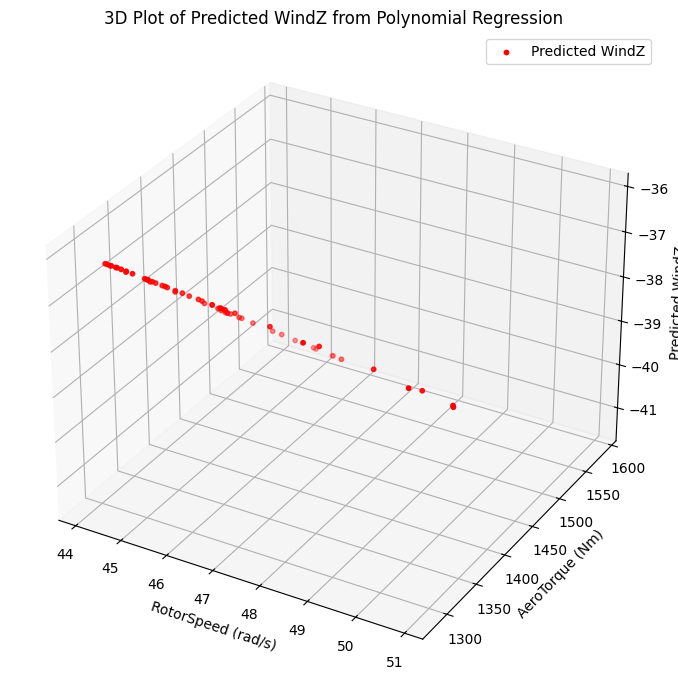

In [311]:
import pandas as pd
import numpy as np

# Load the new motor_simulation_log.csv
df_log = pd.read_csv('motor_simulation_log.csv')

# Extract RotorSpeed_rads and AeroTorque_Nm columns
X_log = df_log[['RotorSpeed_rads', 'AeroTorque_Nm']].values

# Transform the extracted features using the same PolynomialFeatures
X_log_poly = poly.transform(X_log)

# Predict the WindZ (y) using the trained model
y_log_pred = model.predict(X_log_poly)

# Print the predicted WindZ values (y)
df_log['Predicted_WindZ'] = y_log_pred
print(df_log[['RotorSpeed_rads', 'AeroTorque_Nm', 'Predicted_WindZ']])
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df_log contains the 'Predicted_WindZ' column as in the previous code

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data (actual) - you can plot these in red to distinguish them
ax.scatter(df_log['RotorSpeed_rads'], df_log['AeroTorque_Nm'], df_log['Predicted_WindZ'], color='red', label='Predicted WindZ', s=10)

# Set labels and title
ax.set_xlabel('RotorSpeed (rad/s)')
ax.set_ylabel('AeroTorque (Nm)')
ax.set_zlabel('Predicted WindZ')
ax.set_title('3D Plot of Predicted WindZ from Polynomial Regression')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()



In [300]:
import pandas as pd
import numpy as np

# Assuming df_log already contains the 'RotorSpeed_rads', 'AeroTorque_Nm', and 'Predicted_WindZ' columns
# Save the dataframe with the predictions to a CSV
df_log[['RotorSpeed_rads', 'AeroTorque_Nm', 'Predicted_WindZ']].to_csv('predicted_windz.csv', index=False)

print("Predicted WindZ values have been saved to 'predicted_windz.csv'.")


Predicted WindZ values have been saved to 'predicted_windz.csv'.


KeyboardInterrupt: 

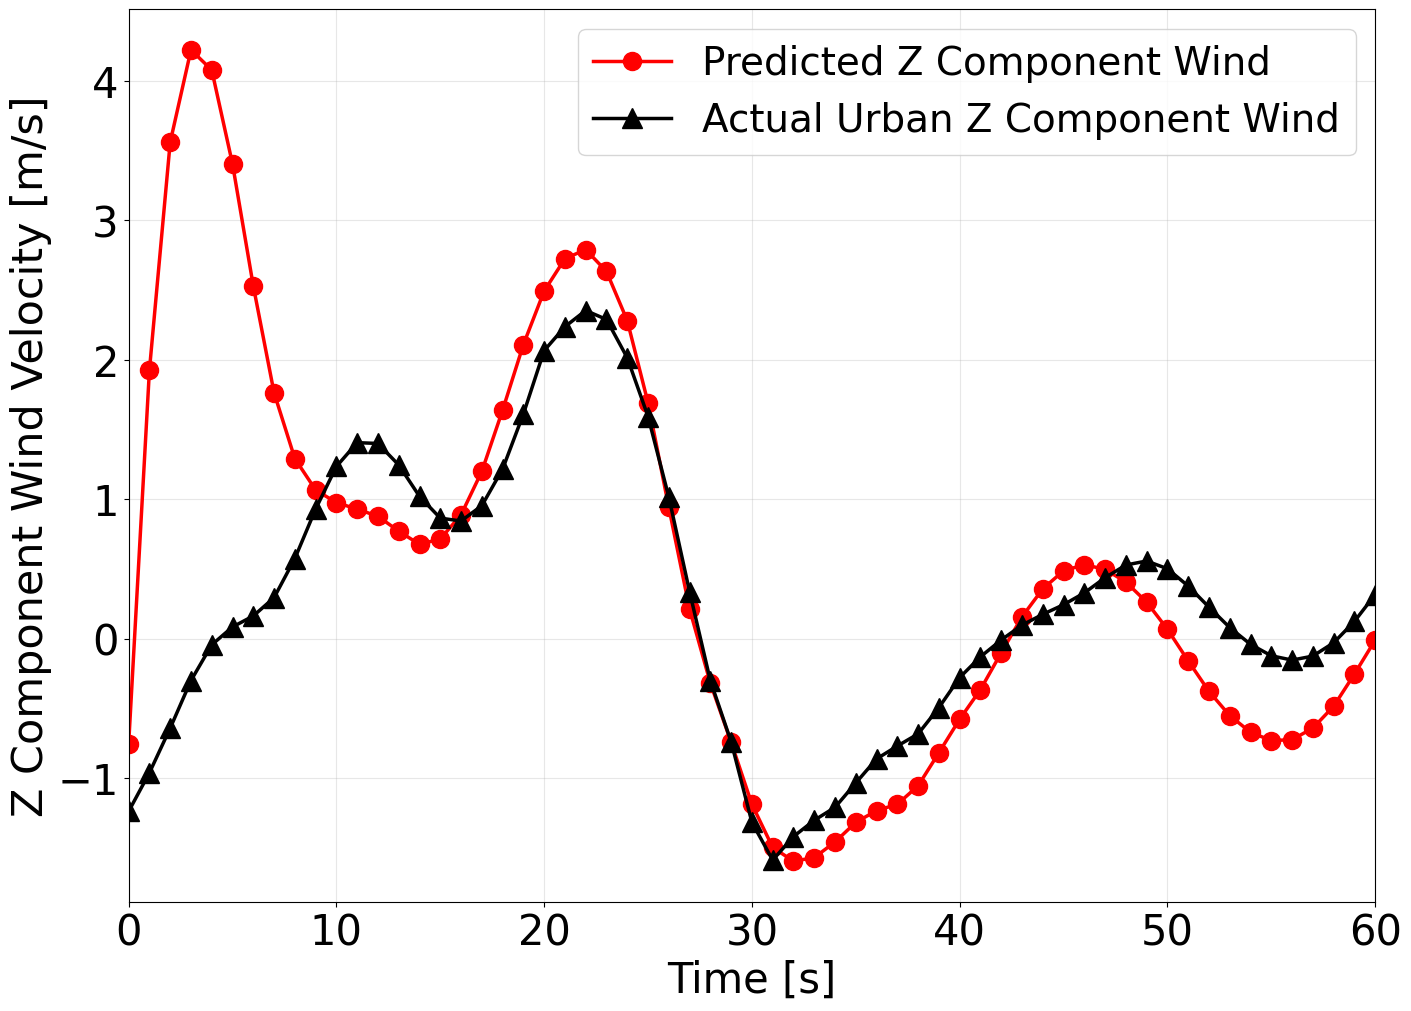

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predicted values from 'predicted_windz.csv'
df_predicted = pd.read_csv('predicted_windz.csv')

# Load the wind_velocities.csv file
df_velocities = pd.read_csv('wind_velocities.csv')

# Extract the columns for Predicted_WindZ and wind_velocity_z
predicted_windz = df_predicted['Predicted_WindZ']
wind_velocity_z = df_velocities['wind_velocity_z']

# Check if the lengths match before plotting
if len(predicted_windz) == len(wind_velocity_z):
    # Create the figure
    plt.figure(figsize=(14, 10))
    
    # Plot both series
    plt.plot(predicted_windz, label='Predicted Z Component Wind', color='r', marker='o',linewidth=2.5, markersize=13)
    plt.plot(wind_velocity_z, label='Actual Urban Z Component Wind', color='black', marker='^', linewidth=2.5, markersize=15)
    
    # Axis labels
    plt.xlabel('Time [s]', fontsize=30)
    plt.ylabel('Z Component Wind Velocity [m/s]', fontsize=31)
    
    # Remove x-axis padding completely by setting exact limits
    plt.xlim(0, len(predicted_windz) - 1)
    
    # Enlarge tick labels
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(True, alpha=0.3)

    # Legend
    plt.legend(fontsize=28)
    
    # Final layout and show
    plt.tight_layout(pad=0.3)
    plt.show()
else:
    print("Error: The lengths of the two datasets do not match!")


In [234]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Read the CSV file
df = pd.read_csv('rpm_wind_simulation_results_correct_3.csv')

# Extract the input (features) and output (target)
X = df[['RPM', 'Propeller_1_Qz']].values          # Independent variables
y = df['WindZ'].values         # Dependent variable

# Choose polynomial degree
degree = 3  # You can try 3, 4, etc. for more complexity

# Generate polynomial features
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict using the model
y_pred = model.predict(X_poly)

# Evaluate the fit
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Print R² and RMSE
print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Get the names of the polynomial terms
feature_names = poly.get_feature_names_out(['RPM', 'Propeller_1_Qz'])

# Display coefficients as variables in the polynomial equation
equation = "y = " + f"{model.intercept_:.6f}"  # Start with the intercept term
for idx, coef in enumerate(model.coef_[1:], 1):  # Skip the first term as it's the intercept
    equation += f" + (a{idx}) * {feature_names[idx]}"

# Print the polynomial equation with variables
print(f"Polynomial Equation: {equation}")

# Display coefficients in a table with variables
coefficients_table = pd.DataFrame({
    'Variable': [f'a{i}' for i in range(1, len(model.coef_))],
    'Feature': feature_names[1:],  # Skip the intercept term
    'Coefficient Value': model.coef_[1:]
})

# Add intercept term in the table
intercept_table = pd.DataFrame({
    'Variable': ['a0'],
    'Feature': ['Intercept'],
    'Coefficient Value': [model.intercept_]
})

# Concatenate intercept term with the rest of the table
coefficients_table = pd.concat([intercept_table, coefficients_table], ignore_index=True)

# Print the table with coefficients and their values
print("\nTable of Coefficients:")
print(coefficients_table)


R² score: 0.9991
RMSE: 0.0589
Polynomial Equation: y = 13.195318 + (a1) * RPM + (a2) * Propeller_1_Qz + (a3) * RPM^2 + (a4) * RPM Propeller_1_Qz + (a5) * Propeller_1_Qz^2 + (a6) * RPM^3 + (a7) * RPM^2 Propeller_1_Qz + (a8) * RPM Propeller_1_Qz^2 + (a9) * Propeller_1_Qz^3

Table of Coefficients:
  Variable               Feature  Coefficient Value
0       a0             Intercept       1.319532e+01
1       a1                   RPM      -1.237085e+00
2       a2        Propeller_1_Qz      -3.372356e-02
3       a3                 RPM^2       1.931337e-02
4       a4    RPM Propeller_1_Qz       6.800628e-04
5       a5      Propeller_1_Qz^2      -1.433633e-06
6       a6                 RPM^3      -1.488128e-04
7       a7  RPM^2 Propeller_1_Qz      -5.059005e-06
8       a8  RPM Propeller_1_Qz^2       8.619500e-09
9       a9      Propeller_1_Qz^3      -1.544791e-10


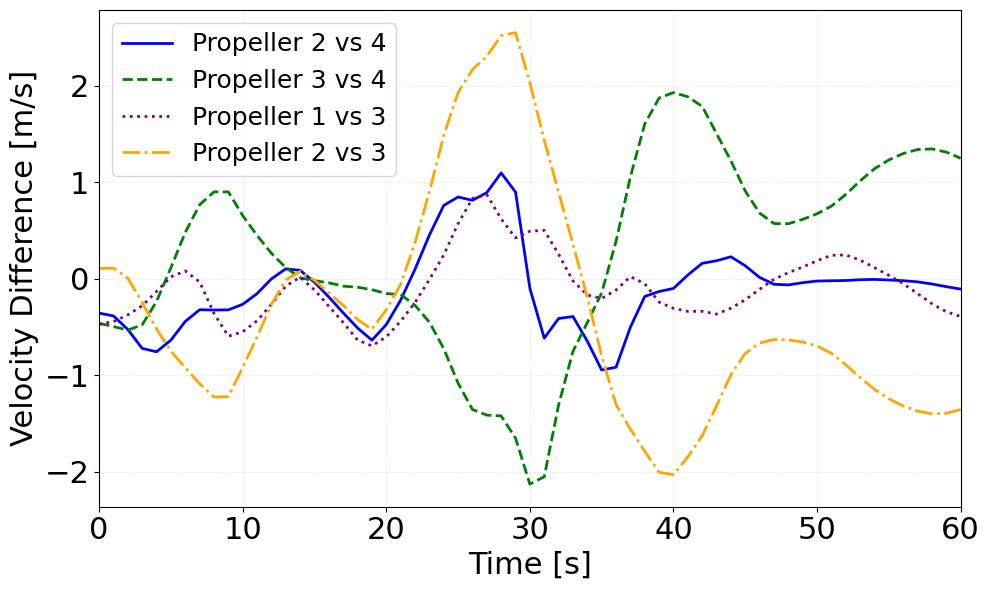

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Define comparison pairs and labels
comparisons = [
    ('Propeller_2_wind_velocities.csv', 'Propeller_4_wind_velocities.csv'),
    ('Propeller_3_wind_velocities.csv', 'Propeller_4_wind_velocities.csv'),
    ('Propeller_1_wind_velocities.csv', 'Propeller_3_wind_velocities.csv'),
    ('Propeller_2_wind_velocities.csv', 'Propeller_3_wind_velocities.csv'),
]

# Define different colors and line styles to distinguish each comparison
line_styles = ['-', '--', ':', '-.']
colors = ['blue', 'green', 'purple', 'orange']  # Different colors for each line

# Set up a smaller figure so fonts appear bigger
plt.figure(figsize=(10, 6))  # Reduced size for higher perceived font size

# Store combined data for max/min calculation
all_velocity_diff = []

# Loop through comparisons with different styles
for i, (file_a, file_b) in enumerate(comparisons):
    # Load data
    df_a = pd.read_csv(file_a)
    df_b = pd.read_csv(file_b)
    
    # Extract wind_velocity_z
    v1 = df_a['wind_velocity_z']
    v2 = df_b['wind_velocity_z']
    
    # Compute difference
    velocity_diff = v2 - v1
    
    # Store for max/min calculation
    all_velocity_diff.extend(velocity_diff)
    
    # Plot velocity_diff with different style and color
    plt.plot(velocity_diff, color=colors[i], linewidth=2,
             linestyle=line_styles[i],
             label=f'Propeller {file_a.split("_")[1]} vs {file_b.split("_")[1]}')

# Find the overall max and min values
max_value = max(all_velocity_diff)
min_value = min(all_velocity_diff)

# # Plot dotted lines at the overall max and min values
# plt.axhline(y=max_value, color='red', linestyle=':', zorder=6)
# plt.axhline(y=min_value, color='blue', linestyle=':', zorder=6)

# Set x-axis limits
plt.xlim(0, 60)

# Increase font sizes for readability
plt.xlabel('Time [s]', fontsize=22)
plt.ylabel('Velocity Difference [m/s]', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# Add legend
plt.legend(fontsize=18, loc='upper left')

# Tight layout
plt.tight_layout()

# Optional: Save the figure in high resolution
# plt.savefig("readable_velocity_plot.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()
